In [51]:
### This Jupyter notebook creates ntype ptype possiblie dopants for input species
### using SMACT structure prediction 
### Working with Kieth from SCIML and Anthony 

from smact.structure_prediction import mutation, utilities
import smact
import re

def get_dopants(original_species: tuple[str], 
                num_dopants=5,
                match_oxi_sign=False) -> dict:
    '''
    Args:
        ex) get_dopants(('Ti4+','O2-'))
        
        original_species (tuple(str)) = ('Cd2+', 'O2-')
        num_dopants (int) = The number of suggestions to return for n- and p-type dopants.
        match_oxi_sign (bool) = ? shoud do some tests
    
    Returns:
        (dict): Dopant suggestions, given as a dictionary with keys 
        "n_type_cation", "p_type_cation", "n_type_anion", "p_type_anion".
    '''
    
    cat, an = original_species
    # utilities.parse_spec('Cd2+') -> ('Cd', 2):(str, int)
    # utilities.parse_spec('O2-') -> ('O', -2):(str, int)
    higher_charge = {'element': utilities.parse_spec(cat)[0],
                    'charge': utilities.parse_spec(cat)[1],}
    lower_charge = {'element': utilities.parse_spec(an)[0],
                    'charge': utilities.parse_spec(an)[1],}  
    
    CM = mutation.CationMutator.from_json()
    
    #call all elements
    element_objects = list(smact.element_dictionary().values())
    poss_n_type_cat = []
    poss_p_type_cat = []
    poss_n_type_an = []
    poss_p_type_an = []
    
    # cation loop to identify species
    for element in element_objects:
        #[-2, -1, 0, +1, +2]
        oxi_state = element.oxidation_states
        els_symbol = element.symbol
        for state in oxi_state:
            if state > higher_charge['charge']:
                poss_n_type_cat.append((els_symbol, state))
            elif state < higher_charge['charge'] and state > 0:
                poss_p_type_cat.append((els_symbol, state))
    
    #anion loop to identify species
    for element in element_objects:
        oxi_state = element.oxidation_states
        els_symbol = element.symbol
        for state in oxi_state:
            if state > lower_charge['charge'] and state < 0:
                poss_n_type_an.append((els_symbol, state))
            elif state < lower_charge['charge']:
                poss_p_type_an.append((els_symbol, state))
    
    # cation loop to calculate substitution probability 
    parsed_poss_n_type_cat = [utilities.unparse_spec(specie) for specie in poss_n_type_cat]
    parsed_poss_p_type_cat = [utilities.unparse_spec(specie) for specie in poss_p_type_cat]
    # anion loop to calculate substitution probability 
    parsed_poss_n_type_an = [utilities.unparse_spec(specie) for specie in poss_n_type_an]
    parsed_poss_p_type_an = [utilities.unparse_spec(specie) for specie in poss_p_type_an]
    
    #calculate substitutional probability for all elememts stored in the list
    n_type_cat = [(specie, CM.sub_prob(cat, specie))
             for specie in parsed_poss_n_type_cat]
    p_type_cat = [(specie, CM.sub_prob(cat, specie))
             for specie in parsed_poss_p_type_cat]
    n_type_an = [(specie, CM.sub_prob(an, specie))
             for specie in parsed_poss_n_type_an]
    p_type_an = [(specie, CM.sub_prob(an, specie))
             for specie in parsed_poss_p_type_an]
    
    #[('B3+', 0.003), ('C4+', 0.001), (), (), ...] : list(tuple(str, float))
    #sort by probability
    n_type_cat.sort(key=lambda x: x[1], reverse=True)
    p_type_cat.sort(key=lambda x: x[1], reverse=True)
    n_type_an.sort(key=lambda x: x[1], reverse=True)
    p_type_an.sort(key=lambda x: x[1], reverse=True)
    
    # return the top (num_dopants) results for each case 
    return {"n-type cation substitutions": n_type_cat[:num_dopants], 
            "p-type cation substitutions": p_type_cat[:num_dopants],
            "n-type anion substitutions": n_type_an[:num_dopants],
            "p-type anion substitutions": p_type_an[:num_dopants]}

get_dopants(('Ti4+','O2-'))

{'n-type cation substitutions': [('Ta5+', 8.790371775858281e-05),
  ('Nb5+', 7.830035204694342e-05),
  ('Sb5+', 6.259166355036722e-05),
  ('Ru5+', 4.904126561555437e-05),
  ('Re5+', 4.546178573532138e-05)],
 'p-type cation substitutions': [('Na1+', 0.00010060400812977031),
  ('Zn2+', 8.56373996146833e-05),
  ('Mn2+', 8.563568688381837e-05),
  ('Mg2+', 6.777016806765154e-05),
  ('Fe3+', 6.259479321178562e-05)],
 'n-type anion substitutions': [('F1-', 0.01508116810515677),
  ('Cl1-', 0.004737202729901607),
  ('Br1-', 0.0010829911758767157),
  ('I1-', 0.0007848025041948803),
  ('H1-', 9.31310255126729e-08)],
 'p-type anion substitutions': [('N3-', 0.0014663800608945628),
  ('C4-', 9.31310255126729e-08),
  ('C3-', 9.31310255126729e-08),
  ('Si4-', 9.31310255126729e-08),
  ('Si3-', 9.31310255126729e-08)]}

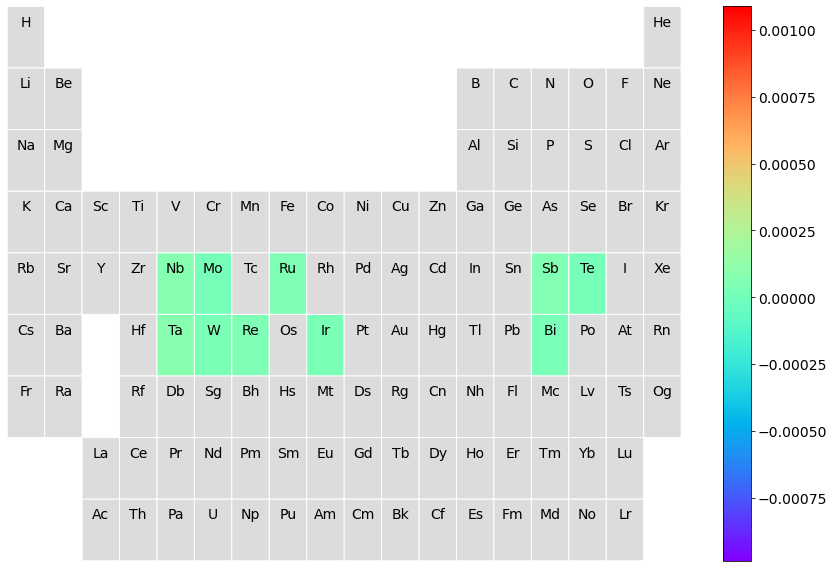

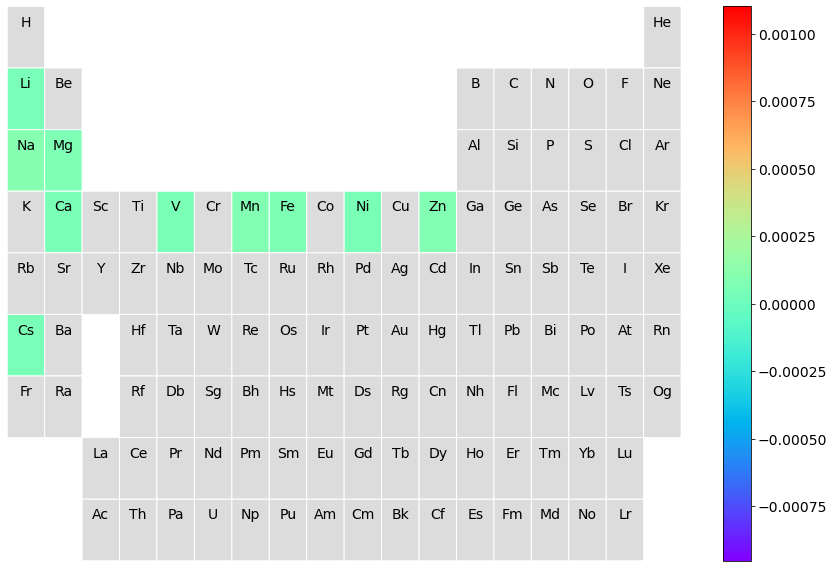

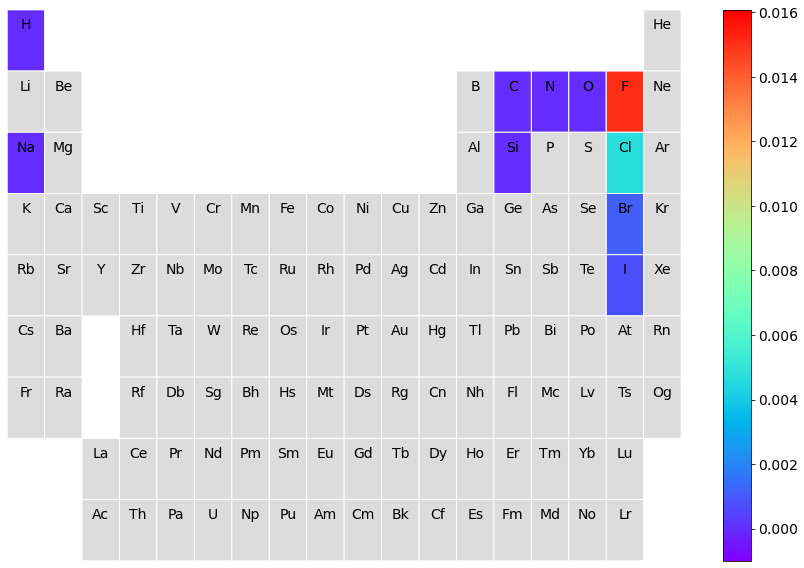

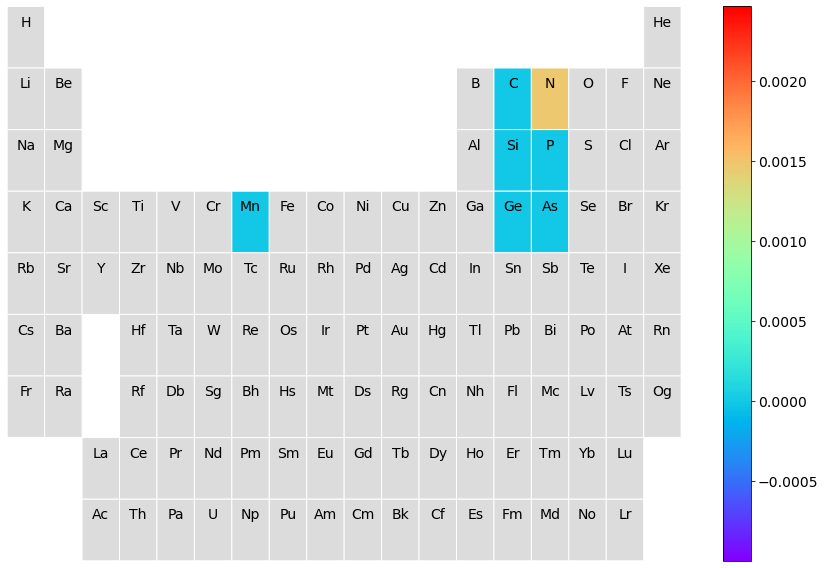

In [52]:
from pymatgen.util import plotting
results = get_dopants(('Ti4+', 'O2-'), num_dopants=10)
for val in results.values():
    dict_results = dict((utilities.parse_spec(x)[0], y) for x, y in val)
    plotting.periodic_table_heatmap(elemental_data=dict_results, cmap='rainbow',
                                    blank_color='gainsboro', edge_color='white')


In [53]:
for i in smact.element_dictionary().values():
    print(i.oxidation_states)

[-1, 1]
[]
[1]
[1, 2]
[1, 2, 3]
[-4, -3, -2, -1, 1, 2, 3, 4]
[-3, -2, -1, 1, 2, 3, 4, 5]
[-2, -1, 1, 2]
[-1]
[]
[-1, 1]
[1, 2]
[1, 2, 3]
[-4, -3, -2, -1, 1, 2, 3, 4]
[-3, -2, -1, 1, 2, 3, 4, 5]
[-2, -1, 1, 2, 3, 4, 5, 6]
[-1, 1, 2, 3, 4, 5, 6, 7]
[]
[-1, 1]
[1, 2]
[1, 2, 3]
[-1, 1, 2, 3, 4]
[-1, 1, 2, 3, 4, 5]
[-2, -1, 1, 2, 3, 4, 5, 6]
[-3, -2, -1, 1, 2, 3, 4, 5, 6, 7]
[-2, -1, 1, 2, 3, 4, 5, 6]
[-1, 1, 2, 3, 4, 5]
[-1, 1, 2, 3, 4]
[1, 2, 3, 4]
[1, 2]
[1, 2, 3]
[-4, -3, -2, -1, 1, 2, 3, 4]
[-3, 1, 2, 3, 5]
[-2, 1, 2, 4, 6]
[-1, 1, 2, 3, 4, 5, 7]
[2]
[-1, 1]
[1, 2]
[1, 2, 3]
[1, 2, 3, 4]
[-1, 1, 2, 3, 4, 5]
[-2, -1, 1, 2, 3, 4, 5, 6]
[-3, -1, 1, 2, 3, 4, 5, 6, 7]
[-2, 1, 2, 3, 4, 5, 6, 7, 8]
[-1, 1, 2, 3, 4, 5, 6]
[1, 2, 4, 6]
[1, 2, 3, 4]
[1, 2]
[1, 2, 3]
[-4, 2, 4]
[-3, 3, 5]
[-2, 2, 4, 5, 6]
[-1, 1, 3, 4, 5, 7]
[1, 2, 4, 6, 8]
[-1, 1]
[2]
[2, 3]
[2, 3, 4]
[2, 3, 4]
[2, 3, 4]
[2, 3]
[2, 3]
[2, 3]
[1, 2, 3]
[1, 2, 3, 4]
[2, 3, 4]
[2, 3]
[2, 3]
[2, 3]
[2, 3]
[3]
[2, 3, 4]
[-1, 2, 3, 4,